In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, model_selection
from sklearn import neighbors
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
#--Importing dataset

df_users=pd.read_csv("data/raw/usagers-2021.csv", sep=";")
df_places=pd.read_csv("data/raw/lieux-2021.csv", sep=";", header=0, low_memory=False)
df_caract=pd.read_csv("data/raw/caracteristiques-2021.csv", sep = ";", encoding='utf-8')
df_veh=pd.read_csv("data/raw/vehicules-2021.csv", sep=";")


# DataSet Users 

In [3]:
#--Visualizing dataset users 

df_users.head(15)
df_users['grav'].value_counts(normalize=True)

grav
 1    0.426688
 4    0.400153
 3    0.147770
 2    0.024924
-1    0.000465
Name: proportion, dtype: float64

In [4]:
#--Calculating the number of victims by accident 

nb_victim = pd.crosstab(df_users.Num_Acc, "count").reset_index()

print(nb_victim)

col_0       Num_Acc  count
0      202100000001      2
1      202100000002      2
2      202100000003      2
3      202100000004      2
4      202100000005      2
...             ...    ...
56513  202100056514      1
56514  202100056515      1
56515  202100056516      2
56516  202100056517      1
56517  202100056518      2

[56518 rows x 2 columns]


In [5]:
#-- Calculating the number of vehicles involved in the accident 
nb_vehicules = pd.crosstab(df_veh.Num_Acc, "count").reset_index()

In [6]:
#--Changing the number associated to injured to make more sens

df_users['grav'] = df_users['grav'].replace([1,2,3,4], [1,3,4,2])

In [7]:
#--Removing variables secu2 and secu3 because they don't bring anything relevant 
df_users.drop(["secu2", "secu3"], inplace=True, axis=1)

In [8]:
#--Adding the age of the victims at the time of the accident

#-Extracting the year of the accident thanks to the accident number
df_users["year_acc"] = df_users["Num_Acc"].astype(str).apply(lambda x : x[:4]).astype(int)

#-Calculating the age the victim
df_users["victim_age"] = df_users["year_acc"]-df_users["an_nais"]
for i in df_users["victim_age"] :
  #- Replacing outliers by NaN
  if (i>120)|(i<0):
    df_users["victim_age"].replace(i,np.nan)

df_users.drop(["year_acc","an_nais"], inplace=True, axis=1)

In [9]:
df_users.isna().sum()

Num_Acc           0
id_vehicule       0
num_veh           0
place             0
catu              0
grav              0
sexe              0
trajet            0
secu1             0
locp              0
actp              0
etatp             0
victim_age     3067
dtype: int64

# Dataset Caracteristics

In [10]:
df_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202100000001,30,11,2021,07:32,2,30,30319,1,1,1,1,CD 981,"44,0389580000","4,3480220000"
1,202100000002,25,9,2021,14:20,1,51,51544,1,3,1,3,Aire de repos croisement D20E9 aprÃ¨s sortie D977,"49,2421290000","4,5545460000"
2,202100000003,15,7,2021,07:55,1,85,85048,2,1,7,6,15 rue FranÃ§ois Nicolas,"46,9219500000","-0,9644600000"
3,202100000004,27,3,2021,19:45,5,93,93005,2,2,3,6,Route de Mitry,"48,9493634583","2,5196639908"
4,202100000005,25,2,2021,07:20,5,76,76429,2,1,1,2,PARIS. ROUTE DE,"49,4083800000","1,1458100000"


In [11]:
#--Replacing column named agg by agg_ since agg is a Python method

df_caract.rename({"agg" : "agg_"},  inplace = True, axis = 1)

In [12]:
#--Replacing Corsica code 2A and 2B by 201 and 202 
corse_replace = {"2A":"201", "2B":"202"}
df_caract["dep"] = df_caract["dep"].str.replace("2A", "201")
df_caract["dep"] = df_caract["dep"].str.replace("2B", "202")
df_caract["com"] = df_caract["com"].str.replace("2A", "201")
df_caract["com"] = df_caract["com"].str.replace("2B", "202")

In [13]:
#--Creating a column datetime
df_caract['datetime_str'] = df_caract['jour'].astype(str) + '/' + df_caract['mois'].astype(str) + '/' + df_caract['an'].astype(str) + ' ' + df_caract['hrmn']
df_caract['datetime'] = pd.to_datetime(df_caract['datetime_str'], format='%d/%m/%Y %H:%M')
df_caract.drop(columns=['datetime_str'], inplace=True)
df_caract["datetime"].sort_values()


56496   2021-01-01 00:00:00
56495   2021-01-01 00:40:00
56132   2021-01-01 00:45:00
56419   2021-01-01 01:00:00
56410   2021-01-01 01:40:00
                ...        
708     2021-12-31 22:45:00
388     2021-12-31 23:00:00
702     2021-12-31 23:30:00
472     2021-12-31 23:40:00
799     2021-12-31 23:50:00
Name: datetime, Length: 56518, dtype: datetime64[ns]

In [14]:
#--Creating a column hour that will replace hrmn

df_caract["hour"] = df_caract["hrmn"].astype(str).apply(lambda x : x[:-3])
df_caract.drop(['hrmn'], inplace=True, axis=1)

In [15]:
#--Convertir columns dep, com and hour into type int
df_caract[["dep","com", "hour"]] = df_caract[["dep","com", "hour"]].astype(int)


In [16]:
df_caract['month'] = df_caract['datetime'].dt.month
df_caract["month"].value_counts()

month
6     5865
10    5832
9     5671
7     5373
5     4835
11    4665
12    4634
8     4590
3     4105
4     3841
1     3757
2     3350
Name: count, dtype: int64

In [17]:
#--Converting columns lat and long into float type

dico_to_float = { 'lat': float, 'long':float}

df_caract["lat"] = df_caract["lat"].str.replace(',', '.')
df_caract["long"] = df_caract["long"].str.replace(',', '.')
df_caract = df_caract.astype(dico_to_float)

df_caract.dtypes

Num_Acc              int64
jour                 int64
mois                 int64
an                   int64
lum                  int64
dep                  int64
com                  int64
agg_                 int64
int                  int64
atm                  int64
col                  int64
adr                 object
lat                float64
long               float64
datetime    datetime64[ns]
hour                 int64
month                int32
dtype: object

In [18]:
#--Removing variable adr because not usable

df_caract = df_caract.drop(columns = 'adr')

In [19]:
df_caract.shape

(56518, 16)

In [20]:
#--Grouping the modalities of the atm ( Atmosheric Conditions) variable into 1 : Risky and 0 : Normal. We include Other in Normal.
print("Modalities of the variable atm : ", df_caract['atm'].unique())
dico = {1:0, 2:1, 3:1, 4:1, 5:1, 6:1,7:1, 8:0, 9:0}
df_caract["atm"] = df_caract["atm"].replace(dico)
df_caract.head()

Modalities of the variable atm :  [ 1  7  3  2  8  9  5  4 -1  6]


,Num_Acc,jour,mois,an,lum,dep,com,agg_,int,atm,col,lat,long,datetime,hour,month
0,202100000001,30,11,2021,2,30,30319,1,1,0,1,44.038958,4.348022,2021-11-30 07:32:00,7,11
1,202100000002,25,9,2021,1,51,51544,1,3,0,3,49.242129,4.554546,2021-09-25 14:20:00,14,9
2,202100000003,15,7,2021,1,85,85048,2,1,1,6,46.921950,-0.964460,2021-07-15 07:55:00,7,7
3,202100000004,27,3,2021,5,93,93005,2,2,1,6,48.949363,2.519664,2021-03-27 19:45:00,19,3
4,202100000005,25,2,2021,5,76,76429,2,1,0,2,49.408380,1.145810,2021-02-25 07:20:00,7,2


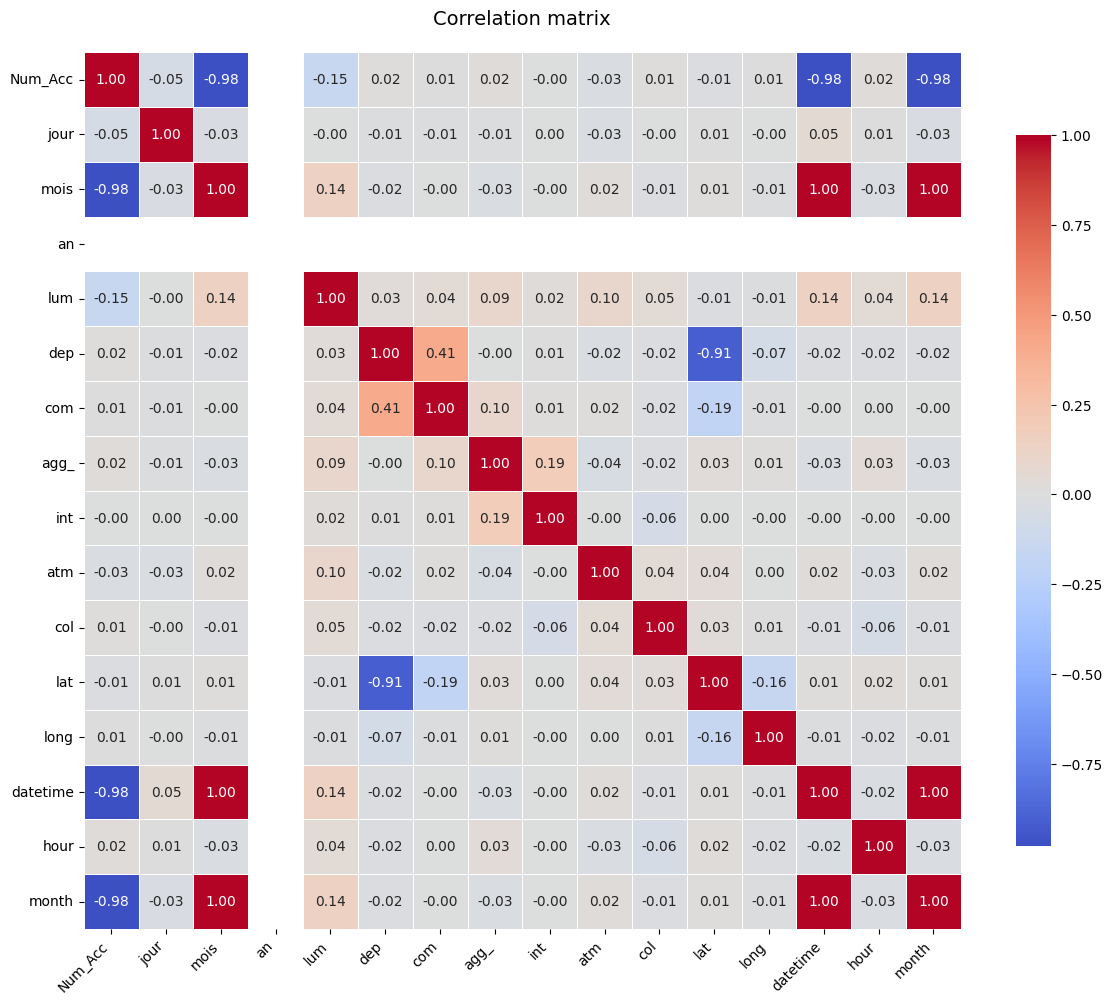

In [21]:
#--Visualizing correlations

df_numerical = df_caract.select_dtypes(include=['int32', 'int64', 'float64', 'datetime'])

correlation_matrix = df_numerical.corr()

# Create a larger figure to accommodate all columns
plt.figure(figsize=(12, 10))

# Create heatmap with adjusted parameters
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    fmt='.2f',  # Format numbers to 2 decimal places (makes them smaller)
    square=True,  # Make cells square
    linewidths=0.5,  # Add lines between cells for clarity
    cbar_kws={"shrink": 0.8}  # Make colorbar smaller
)

plt.title('Correlation matrix', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# Dataset Vehicles 

In [22]:
df_veh.head()


,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202100000001,201Â 764,B01,1,1,0,2,1,1,5,NaN
1,202100000001,201Â 765,A01,1,7,0,9,3,17,1,NaN
2,202100000002,201Â 762,A01,0,7,2,2,1,1,0,NaN
3,202100000002,201Â 763,B01,0,7,0,2,1,9,0,NaN
4,202100000003,201Â 761,A01,1,7,0,1,3,1,1,NaN


In [23]:
df_veh.catv.unique()

array([ 1,  7, 60, 32, 99, 37, 10,  2, 15, 14,  0, 33, 31, 34, 30, 50,  3,
       39, 36, 13, 80, 43, 38, 20, 40, 17, 35, 21, 16, 41, -1, 42])

In [24]:
df_veh["id_vehicule"].duplicated().sum()

np.int64(0)

In [25]:
df_veh.isna().sum()

Num_Acc            0
id_vehicule        0
num_veh            0
senc               0
catv               0
obs                0
obsm               0
choc               0
manv               0
motor              0
occutc         96571
dtype: int64

# Merging datasets

In [26]:
df_users.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,actp,etatp,victim_age
0,202100000001,201Â 764,B01,1,1,4,1,1,0,0,0,-1,21.0
1,202100000001,201Â 765,A01,1,1,1,1,1,1,0,0,-1,43.0
2,202100000002,201Â 762,A01,1,1,2,1,0,1,0,0,-1,38.0
3,202100000002,201Â 763,B01,1,1,4,1,0,1,0,0,-1,28.0
4,202100000003,201Â 761,A01,1,1,1,1,1,1,0,0,-1,26.0


In [27]:
#--Merging datasets users and vehicles

fusion1= df_users.merge(df_veh, on = ["Num_Acc","num_veh", "id_vehicule"], how="inner")


In [28]:
#--Keeping 1 line by accident and keeping the most severe injured person

fusion1 = fusion1.sort_values(by = "grav", ascending = False)
fusion1 = fusion1.drop_duplicates(subset = ['Num_Acc'], keep="first")
fusion1.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,...,etatp,victim_age,senc,catv,obs,obsm,choc,manv,motor,occutc
129152,202100056518,100Â 883,B01,1,1,4,1,3,1,-1,...,-1,36.0,1,7,0,2,1,1,1,NaN
129133,202100056508,100Â 898,A01,1,1,4,1,5,2,0,...,-1,46.0,2,1,0,0,8,1,5,NaN
129130,202100056505,100Â 901,A01,1,1,4,1,5,6,0,...,-1,48.0,0,33,6,0,1,0,1,NaN
129125,202100056501,100Â 906,A01,2,2,4,2,0,8,-1,...,-1,26.0,1,7,4,0,2,14,1,NaN
32,202100000013,201Â 739,B01,1,1,4,1,5,2,0,...,-1,17.0,1,2,0,0,4,2,1,NaN


In [29]:
fusion2 = fusion1.merge(df_places, on = "Num_Acc", how = "left")

In [30]:
df = fusion2.merge(df_caract, on = 'Num_Acc', how="left")

In [31]:
df.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,...,com,agg_,int,atm,col,lat,long,datetime,hour,month
0,202100056518,100Â 883,B01,1,1,4,1,3,1,-1,...,78423,1,1,1,1,48.796670,2.050500,2021-01-02 18:00:00,18,1
1,202100056508,100Â 898,A01,1,1,4,1,5,2,0,...,64400,1,1,0,7,43.146573,-0.195544,2021-01-01 12:20:00,12,1
2,202100056505,100Â 901,A01,1,1,4,1,5,6,0,...,34147,2,3,0,6,43.471449,3.222046,2021-01-01 05:15:00,5,1
3,202100056501,100Â 906,A01,2,2,4,2,0,8,-1,...,94011,1,1,0,6,48.761228,2.491207,2021-01-01 18:00:00,18,1
4,202100000013,201Â 739,B01,1,1,4,1,5,2,0,...,97418,1,1,0,2,-20.931080,55.537219,2021-12-18 01:15:00,1,12


In [32]:
#--Adding the number of victims
df = df.merge(nb_victim, on = "Num_Acc", how = "inner")

df.rename({"count" :"nb_victim"},axis = 1, inplace = True) 

In [33]:
#--Adding the number of vehicles 

df = df.merge(nb_vehicules, on = "Num_Acc", how = "inner") 
df.rename({"count" :"nb_vehicules"},axis = 1, inplace = True)

In [34]:
df['grav'].unique()

array([4, 3, 2])

In [35]:
#--Modification of the target variable  : 1 : prioritary// 0 : non-prioritary

df['grav'] = df['grav'].replace([2,3,4], [0,1,1])
df

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,trajet,secu1,locp,...,int,atm,col,lat,long,datetime,hour,month,nb_victim,nb_vehicules
0,202100056518,100Â 883,B01,1,1,1,1,3,1,-1,...,1,1,1,48.796670,2.050500,2021-01-02 18:00:00,18,1,2,2
1,202100056508,100Â 898,A01,1,1,1,1,5,2,0,...,1,0,7,43.146573,-0.195544,2021-01-01 12:20:00,12,1,1,1
2,202100056505,100Â 901,A01,1,1,1,1,5,6,0,...,3,0,6,43.471449,3.222046,2021-01-01 05:15:00,5,1,1,1
3,202100056501,100Â 906,A01,2,2,1,2,0,8,-1,...,1,0,6,48.761228,2.491207,2021-01-01 18:00:00,18,1,2,1
4,202100000013,201Â 739,B01,1,1,1,1,5,2,0,...,1,0,2,-20.931080,55.537219,2021-12-18 01:15:00,1,12,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56513,202100048124,115Â 725,A01,10,3,0,2,5,0,9,...,1,1,6,48.714000,2.395880,2021-03-13 18:00:00,18,3,3,1
56514,202100048122,115Â 727,B01,2,1,0,1,9,8,-1,...,9,0,3,16.289340,-61.480750,2021-03-12 14:51:00,14,3,2,2
56515,202100048121,115Â 729,A01,1,1,0,1,4,8,-1,...,2,0,3,45.700810,4.824090,2021-03-12 09:30:00,9,3,2,2
56516,202100048120,115Â 732,A01,1,1,0,1,0,8,-1,...,3,0,3,45.725370,4.816720,2021-03-13 13:15:00,13,3,2,2


In [36]:

#--Calculating the number of missing values for each column
missing_values_count = df.isnull().sum()

#--Calculating the percentage of missing values for each variables 
total_cells = len(df)
missing_percentage = (missing_values_count / total_cells) * 100

#--Creating a new dataframe with the percentage of missing values 
missing_df = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})

missing_df = missing_df.sort_values(by='MissingPercentage', ascending=False)

print(missing_df[missing_df["MissingPercentage"] >= 70])

    Column  MissingPercentage
32  lartpc          99.808910
20  occutc          99.403730
24      v2          91.170954


In [37]:
#--Removing variables with more than 70% of missing values 
list_to_drop = missing_df[missing_df["MissingPercentage"] >= 70]["Column"].tolist()

df.drop(list_to_drop, inplace=True, axis=1)

In [38]:
# changed: I will not drop these:
open_to_drop = ['v1', 'vosp','locp','etatp', 'infra', 'obs']
# v1 == Art der Verkehrsfläche
# vosp == Sonderfahrbahn / besondere Verkehrsfläche
# locp = Fußgänger-Positionsvariable
# etatp = Zustand der Fahrbahn
# infra = Infrastruktur (Brücke, Tunnel... )
# obs = Festes Hindernis
for col in open_to_drop:
    display(df[col].value_counts())

v1
 0    46596
-1     9823
 2       79
 3       20
Name: count, dtype: int64

vosp
 0    49789
 1     2981
 3     2109
 2     1429
-1      210
Name: count, dtype: int64

locp
-1    24673
 0    23376
 3     2612
 2     1993
 4     1302
 1     1264
 5      594
 9      361
 6      217
 8      118
 7        8
Name: count, dtype: int64

etatp
-1    48036
 1     6808
 2     1417
 3      257
Name: count, dtype: int64

infra
 0    47504
 5     2989
 9     1995
 2      899
 3      730
 1      658
-1      619
 6      502
 8      385
 4      208
 7       29
Name: count, dtype: int64

obs
 0     44754
 1      1685
 13     1542
 2      1342
 4      1113
 8       995
 6       987
 3       955
 12      676
 14      502
 15      489
 9       413
 16      342
 7       236
 5       152
 11      137
 10      100
 17       83
-1        15
Name: count, dtype: int64

In [39]:
df.columns

Index(['Num_Acc', 'id_vehicule', 'num_veh', 'place', 'catu', 'grav', 'sexe',
       'trajet', 'secu1', 'locp', 'actp', 'etatp', 'victim_age', 'senc',
       'catv', 'obs', 'obsm', 'choc', 'manv', 'motor', 'catr', 'voie', 'v1',
       'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'larrout', 'surf',
       'infra', 'situ', 'vma', 'jour', 'mois', 'an', 'lum', 'dep', 'com',
       'agg_', 'int', 'atm', 'col', 'lat', 'long', 'datetime', 'hour', 'month',
       'nb_victim', 'nb_vehicules'],
      dtype='object')

In [40]:
catv_value = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,30,31,32,33,34,35,36,37,38,39,40,41,42,43,50,60,80,99]
catv_value_new = [0,1,1,2,1,1,6,2,5,5,5,5,5,4,4,4,4,4,3,3,4,4,1,1,1,1,1,6,6,3,3,3,3,1,1,1,1,1,0,0]

df['catv'] = df['catv'].replace(catv_value, catv_value_new)


In [41]:
#--Replacing values -1 et 0 par NaN
col_to_replace0_na = ["actp", "trajet", "catv", "motor"]
col_to_replace1_na = ["actp", "trajet", "secu1", "catv", "obsm", "motor", "circ", "larrout", "surf", "situ", "vma", "atm", "col"]
df2 = df.copy()
df[col_to_replace1_na] = df[col_to_replace1_na].replace(-1, np.nan)
df[col_to_replace0_na] = df[col_to_replace0_na].replace(0, np.nan)

In [42]:
for column in df.columns[15:]:
    print(f"Modalities of the variable {column} : ", df[column].unique())

Modalities of the variable obs :  [ 0  6  4 16 17  1  3  8  2 14 15 13  7  9 -1 10  5 12 11]
Modalities of the variable obsm :  [ 2.  0.  1.  9.  4.  6. nan  5.]
Modalities of the variable choc :  [ 1  8  2  4  0  3  7  9  5  6 -1]
Modalities of the variable manv :  [ 1  0 14  2 19  9 13  5 15 17 26 23 21  3 25  7 16 18 12  4 20 11 10 -1
  8  6 24 22]
Modalities of the variable motor :  [ 1.  5. nan  6.  3.  2.  4.]
Modalities of the variable catr :  [3 4 2 1 7 5 9 6]
Modalities of the variable voie :  ['129' '2' '18' ... 'BERNARD PALISSY (RUE)'
 '8 MAI 1945 (DU)                     (R )' 'RUE DU CHEMIN DE FER']
Modalities of the variable v1 :  [ 0 -1  3  2]
Modalities of the variable circ :  [ 2.  3. nan  1.  4.]
Modalities of the variable nbv :  [ 2  4  1  3  5  6  0 -1  9  7  8 10 12 11]
Modalities of the variable vosp :  [ 0  3 -1  1  2]
Modalities of the variable prof :  [ 1  2  4  3 -1]
Modalities of the variable pr :  ['2' '0' '38' '5' '10' '4' '24' '1' '(1)' '15' '204' '259' '1

In [43]:
#--Removing variables that do not match with our goal to predict the severity of the accident 

list_to_drop = ['senc', 'manv', 'choc', 'nbv', 'Num_Acc', 'id_vehicule', 'num_veh', 'pr', 'pr1','voie', 'trajet' ]

df.drop(list_to_drop, axis=1, inplace=True)

# not dropping prof --> it could be relevant ( profil de la route = uphill, downhill)
# not dropping plan --> it could be relevant ( horizontal, curve, intersection)

In [44]:
#--Replacing modalities A and B by 10 and 11
df["actp"] = df["actp"].str.replace("A","10")
df["actp"] = df["actp"].str.replace("B","11")
df["actp"] = df["actp"].astype(int)

In [45]:
df.select_dtypes(['object']).columns

Index(['larrout'], dtype='object')

In [46]:
#--Converting larrout into float
df["larrout"] = df["larrout"].str.replace(",",".")
df["larrout"] = df["larrout"].astype(float)

In [47]:
#--Fill NaN with mode 
col_to_fill_na = ["surf", "situ", "circ", "col", "motor"]

df[col_to_fill_na] = df[col_to_fill_na].fillna(df[col_to_fill_na].mode().iloc[0])


In [48]:
df.isna().sum()[df.isna().sum() > 0]

secu1     63
catv     878
obsm      24
vma      875
atm        8
dtype: int64

In [49]:
#Drop NaN 
df = df.dropna(axis=0)

In [50]:
df.head()

,place,catu,grav,sexe,secu1,locp,actp,etatp,victim_age,catv,...,int,atm,col,lat,long,datetime,hour,month,nb_victim,nb_vehicules
0,1,1,1,1,1.0,-1,-1,-1,36.0,2.0,...,1,1.0,1.0,48.796670,2.050500,2021-01-02 18:00:00,18,1,2,2
1,1,1,1,1,2.0,0,0,-1,46.0,1.0,...,1,0.0,7.0,43.146573,-0.195544,2021-01-01 12:20:00,12,1,1,1
2,1,1,1,1,6.0,0,0,-1,48.0,1.0,...,3,0.0,6.0,43.471449,3.222046,2021-01-01 05:15:00,5,1,1,1
3,2,2,1,2,8.0,-1,-1,-1,26.0,2.0,...,1,0.0,6.0,48.761228,2.491207,2021-01-01 18:00:00,18,1,2,1
4,1,1,1,1,2.0,0,0,-1,17.0,1.0,...,1,0.0,2.0,-20.931080,55.537219,2021-12-18 01:15:00,1,12,3,2


# Finale Version Preprocessing Summary

In [51]:
# Finale version of the preprocessing steps :

#--Importing dataset
df_users=pd.read_csv("data/raw/usagers-2021.csv", sep=";")
df_places=pd.read_csv("data/raw/lieux-2021.csv", sep=";", header=0, low_memory=False)
df_caract=pd.read_csv("data/raw/caracteristiques-2021.csv", sep = ";", encoding='utf-8')
df_veh=pd.read_csv("data/raw/vehicules-2021.csv", sep=";")

#--Calculating number of victims and vehicles by accident
nb_victim = pd.crosstab(df_users.Num_Acc, "count").reset_index()
nb_vehicules = pd.crosstab(df_veh.Num_Acc, "count").reset_index()

#--Users dataset preprocessing
# Changing grav values
df_users['grav'] = df_users['grav'].replace([1,2,3,4], [1,3,4,2])

# Removing secu2 and secu3
df_users.drop(["secu2", "secu3"], inplace=True, axis=1)

# Adding victim_age
df_users["year_acc"] = df_users["Num_Acc"].astype(str).apply(lambda x : x[:4]).astype(int)
df_users["victim_age"] = df_users["year_acc"]-df_users["an_nais"]
for i in df_users["victim_age"] :
    if (i>120)|(i<0):
        df_users["victim_age"].replace(i,np.nan)
df_users.drop(["year_acc","an_nais"], inplace=True, axis=1)

#--Caracteristics dataset preprocessing
# Rename agg to agg_
df_caract.rename({"agg" : "agg_"},  inplace = True, axis = 1)

# Replace Corsica codes
df_caract["dep"] = df_caract["dep"].str.replace("2A", "201")
df_caract["dep"] = df_caract["dep"].str.replace("2B", "202")
df_caract["com"] = df_caract["com"].str.replace("2A", "201")
df_caract["com"] = df_caract["com"].str.replace("2B", "202")

# Creating datetime column
df_caract['datetime_str'] = df_caract['jour'].astype(str) + '/' + df_caract['mois'].astype(str) + '/' + df_caract['an'].astype(str) + ' ' + df_caract['hrmn']
df_caract['datetime'] = pd.to_datetime(df_caract['datetime_str'], format='%d/%m/%Y %H:%M')
df_caract.drop(columns=['datetime_str'], inplace=True)

# Creating hour column
df_caract["hour"] = df_caract["hrmn"].astype(str).apply(lambda x : x[:-3])
df_caract.drop(['hrmn'], inplace=True, axis=1)

# Creating month column
df_caract['month'] = df_caract['datetime'].dt.month

# Converting columns types
df_caract[["dep","com", "hour"]] = df_caract[["dep","com", "hour"]].astype(int)

# Converting lat and long to float
df_caract["lat"] = df_caract["lat"].str.replace(',', '.')
df_caract["long"] = df_caract["long"].str.replace(',', '.')
dico_to_float = { 'lat': float, 'long':float}
df_caract = df_caract.astype(dico_to_float)

# Removing adr column
df_caract = df_caract.drop(columns = 'adr')

# Grouping atm modalities
dico = {1:0, 2:1, 3:1, 4:1, 5:1, 6:1,7:1, 8:0, 9:0}
df_caract["atm"] = df_caract["atm"].replace(dico)

#--Vehicles dataset preprocessing
# Grouping catv modalities
catv_value = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,30,31,32,33,34,35,36,37,38,39,40,41,42,43,50,60,80,99]
catv_value_new = [0,1,1,2,1,1,6,2,5,5,5,5,5,4,4,4,4,4,3,3,4,4,1,1,1,1,1,6,6,3,3,3,3,1,1,1,1,1,0,0]
df_veh['catv'] = df_veh['catv'].replace(catv_value, catv_value_new)

#--Merging datasets
fusion1= df_users.merge(df_veh, on = ["Num_Acc","num_veh", "id_vehicule"], how="inner")
fusion1 = fusion1.sort_values(by = "grav", ascending = False)
fusion1 = fusion1.drop_duplicates(subset = ['Num_Acc'], keep="first")
fusion2 = fusion1.merge(df_places, on = "Num_Acc", how = "left")
df = fusion2.merge(df_caract, on = 'Num_Acc', how="left")

#--Adding new columns
df = df.merge(nb_victim, on = "Num_Acc", how = "inner")
df.rename({"count" :"nb_victim"},axis = 1, inplace = True) 
df = df.merge(nb_vehicules, on = "Num_Acc", how = "inner") 
df.rename({"count" :"nb_vehicules"},axis = 1, inplace = True)

#--Modification of the target variable: 1 : prioritary // 0 : non-prioritary
df['grav'] = df['grav'].replace([2,3,4], [0,1,1])

#--Removing variables with more than 70% missing values
missing_values_count = df.isnull().sum()
total_cells = len(df)
missing_percentage = (missing_values_count / total_cells) * 100
missing_df = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})
missing_df = missing_df.sort_values(by='MissingPercentage', ascending=False)
list_to_drop_missing = missing_df[missing_df["MissingPercentage"] >= 70]["Column"].tolist()
df.drop(list_to_drop_missing, inplace=True, axis=1)

#--Replacing values -1 and 0 with NaN
col_to_replace0_na = ["actp", "trajet", "catv", "motor"]
col_to_replace1_na = ["actp", "trajet", "secu1", "catv", "obsm", "motor", "circ", "larrout", "surf", "situ", "vma", "atm", "col"]
df[col_to_replace1_na] = df[col_to_replace1_na].replace(-1, np.nan)
df[col_to_replace0_na] = df[col_to_replace0_na].replace(0, np.nan)

#--Converting actp from string to int (A->10, B->11)
df["actp"] = df["actp"].str.replace("A","10")
df["actp"] = df["actp"].str.replace("B","11")
df["actp"] = df["actp"].astype(int)

#--Converting larrout to float
df["larrout"] = df["larrout"].str.replace(",",".")
df["larrout"] = df["larrout"].astype(float)

#--Dropping columns
list_to_drop = ['senc', 'manv', 'choc', 'nbv', 'Num_Acc', 'id_vehicule', 'num_veh', 'pr', 'pr1','voie', 'trajet', 'jour', 'mois', 'an']
df.drop(list_to_drop, axis=1, inplace=True)

#--Filling NaN values with mode
col_to_fill_na = ["surf", "situ", "circ", "col", "motor"]
df[col_to_fill_na] = df[col_to_fill_na].fillna(df[col_to_fill_na].mode().iloc[0])

#--Dropping all remaining NaN rows
df = df.dropna(axis=0)

display(df.head())
display(df.info())

target = df['grav']
feats = df.drop(['grav'], axis = 1)

#--Dropping datetime column before model training
# Note: datetime column is dropped because sklearn models require numeric data only.
# The temporal information is already captured in 'hour' and 'month' columns extracted from datetime.
feats = feats.drop(['datetime'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.3, random_state = 42)

,place,catu,grav,sexe,secu1,locp,actp,etatp,victim_age,catv,...,int,atm,col,lat,long,datetime,hour,month,nb_victim,nb_vehicules
0,1,1,1,1,1.0,-1,-1,-1,36.0,2.0,...,1,1.0,1.0,48.796670,2.050500,2021-01-02 18:00:00,18,1,2,2
1,1,1,1,1,2.0,0,0,-1,46.0,1.0,...,1,0.0,7.0,43.146573,-0.195544,2021-01-01 12:20:00,12,1,1,1
2,1,1,1,1,6.0,0,0,-1,48.0,1.0,...,3,0.0,6.0,43.471449,3.222046,2021-01-01 05:15:00,5,1,1,1
3,2,2,1,2,8.0,-1,-1,-1,26.0,2.0,...,1,0.0,6.0,48.761228,2.491207,2021-01-01 18:00:00,18,1,2,1
4,1,1,1,1,2.0,0,0,-1,17.0,1.0,...,1,0.0,2.0,-20.931080,55.537219,2021-12-18 01:15:00,1,12,3,2


<class 'pandas.core.frame.DataFrame'>
Index: 54699 entries, 0 to 56517
Data columns (total 38 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   place         54699 non-null  int64         
 1   catu          54699 non-null  int64         
 2   grav          54699 non-null  int64         
 3   sexe          54699 non-null  int64         
 4   secu1         54699 non-null  float64       
 5   locp          54699 non-null  int64         
 6   actp          54699 non-null  int64         
 7   etatp         54699 non-null  int64         
 8   victim_age    54699 non-null  float64       
 9   catv          54699 non-null  float64       
 10  obs           54699 non-null  int64         
 11  obsm          54699 non-null  float64       
 12  motor         54699 non-null  float64       
 13  catr          54699 non-null  int64         
 14  v1            54699 non-null  int64         
 15  circ          54699 non-null  float64    

None

In [52]:
X_train.shape

(38289, 36)

In [53]:
# Select lines to run a gridsearch 
num_random_rows = 5000
X_train_reduced = X_train.sample(n=num_random_rows, random_state = 42)
X_train_reduced.shape
y_train_reduced = y_train.sample(n=num_random_rows, random_state = 42)

In [54]:
# Select best features for the median for categorical variables
# Drop datetime column as sklearn models require numeric data only
# (hour and month are already extracted from datetime)
X_train_numeric = X_train.select_dtypes(include=[np.number])

selector_median = SelectFromModel(SGDClassifier(random_state = 0), threshold = 'median')

selector_median.fit_transform(X_train_numeric, y_train)

feats_sgdc_med = X_train_numeric.columns[selector_median.get_support()]
print("les va les plus explicatives selectionnées par mediane sont:", X_train_numeric.columns[selector_median.get_support()])

les va les plus explicatives selectionnées par mediane sont: Index(['secu1', 'locp', 'actp', 'victim_age', 'obs', 'obsm', 'v1', 'larrout',
       'situ', 'vma', 'dep', 'agg_', 'int', 'col', 'lat', 'long', 'hour',
       'nb_vehicules'],
      dtype='object')


In [55]:
lr_select = LogisticRegression(class_weight='balanced')
lr_select.fit(X_train_reduced, y_train_reduced)

# Visualization of false positives and false negatives

y_pred_lr = lr_select.predict(X_test)

print(pd.crosstab(y_test, y_pred_lr, rownames=['Classe réelle'], colnames=['Classe prédite']))


Classe prédite     0     1
Classe réelle             
0               7594  3143
1               2193  3480


/home/christianm/Projects/Repos/MLOps_accidents/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
f1_score_value = f1_score(y_test, y_pred_lr)

print("F1-score:", f1_score_value)

F1-score: 0.5660377358490566


In [57]:
dt_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=4, random_state=123)

dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [58]:

# Prediction of test features and creation of the confusion matrix
y_pred = dt_clf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Real class'], colnames=['Predict class'])
f1_score_value = f1_score(y_test, y_pred)

print("F1-score:", f1_score_value)

F1-score: 0.6089049338146811


In [59]:
feats = {}
for feature, importance in zip(df.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)


,Importance
catr,0.394275
com,0.229174
secu1,0.167148
col,0.101802
sexe,0.048951
lum,0.020894
dep,0.020028
month,0.007636


In [60]:
dt_clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=321)
dt_clf_gini.fit(X_train, y_train)
y_pred = dt_clf_gini.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Real class'], colnames=['Predict class'])
f1_score_value = f1_score(y_test, y_pred)

print("F1-score:", f1_score_value)

F1-score: 0.6412825651302605


In [61]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski')

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f1_score(y_test, y_pred))

0.5956492049556141


In [62]:
score_minko = []
score_man = []
score_cheb = []

for i in range(1, 10):
    knn_mink = neighbors.KNeighborsClassifier(n_neighbors = i, metric = 'minkowski').fit(X_train_reduced.values, y_train_reduced.values)
    knn_man = neighbors.KNeighborsClassifier(n_neighbors = i, metric = 'manhattan').fit(X_train_reduced.values, y_train_reduced.values)
    knn_cheb = neighbors.KNeighborsClassifier(n_neighbors = i, metric = 'chebyshev').fit(X_train_reduced.values, y_train_reduced.values)
    y_pred_mink = knn_mink.predict(X_test.values)
    y_pred_man = knn_man.predict(X_test.values)
    y_pred_cheb = knn_cheb.predict(X_test.values)
    score_minko.append(f1_score(y_test, y_pred_mink))
    score_man.append(f1_score(y_test, y_pred_man))
    score_cheb.append(f1_score(y_test, y_pred_cheb))

print(score_minko)

[np.float64(0.5228177358141257), np.float64(0.39606366176649255), np.float64(0.5375671714704445), np.float64(0.4565688848304988), np.float64(0.5444137386498223), np.float64(0.4712230215827338), np.float64(0.5298643450091112), np.float64(0.47819383259911896), np.float64(0.528444489837606)]


In [63]:
rf_classifier = ensemble.RandomForestClassifier(n_jobs=-1)

#--Train the model
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
f1 = f1_score(y_test, y_pred)


X_test.head()


,place,catu,sexe,secu1,locp,actp,etatp,victim_age,catv,obs,...,agg_,int,atm,col,lat,long,hour,month,nb_victim,nb_vehicules
25463,2,2,1,1.0,-1,-1,-1,77.0,2.0,0,...,2,2,0.0,1.0,43.58236,5.003470,18,4,3,2
16943,10,3,2,0.0,3,3,2,5.0,2.0,0,...,2,1,0.0,6.0,-20.89749,55.480630,19,11,4,1
43056,1,1,1,1.0,-1,-1,-1,28.0,2.0,1,...,2,2,0.0,3.0,46.49463,-1.766410,6,1,2,2
38997,1,1,2,1.0,0,0,-1,52.0,2.0,0,...,1,1,1.0,3.0,49.92430,2.292130,8,2,2,2
15935,10,3,2,0.0,5,1,1,19.0,2.0,0,...,2,2,0.0,6.0,48.88298,2.296384,20,10,3,1


In [64]:
clf = ensemble.RandomForestClassifier()

# Définir la grille des hyperparamètres à explorer
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')

# Effectuer la recherche sur la grille
grid_search.fit(X_train_reduced, y_train_reduced)

# Afficher les meilleurs paramètres et score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

# Utiliser le modèle avec les meilleurs paramètres
best_clf = grid_search.best_estimator_
y_pred_rf = best_clf.predict(X_test)

# Calculer et afficher le score F1 sur les données de test
f1 = f1_score(y_test, y_pred_rf)
print("Score F1 sur les données de test:", f1)

Meilleurs paramètres: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Meilleur score F1: 0.6538532128211674
Score F1 sur les données de test: 0.6424195273752796


In [65]:
dico = {k: 0 for k in X_test.columns}

df_test = pd.DataFrame([dico])
print(rf_classifier.predict(df_test))

[0]


In [66]:
# Supprimez la limite de lignes et de colonnes pour l'affichage
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
y_pred_rf
X_test.head()

,place,catu,sexe,secu1,locp,actp,etatp,victim_age,catv,obs,obsm,motor,catr,v1,circ,vosp,prof,plan,larrout,surf,infra,situ,vma,lum,dep,com,agg_,int,atm,col,lat,long,hour,month,nb_victim,nb_vehicules
25463,2,2,1,1.0,-1,-1,-1,77.0,2.0,0,2.0,1.0,4,0,2.0,0,1,1,-1.0,1.0,5,1.0,50.0,2,13,13063,2,2,0.0,1.0,43.58236,5.003470,18,4,3,2
16943,10,3,2,0.0,3,3,2,5.0,2.0,0,1.0,1.0,4,0,2.0,0,1,1,-1.0,1.0,0,1.0,30.0,5,974,97411,2,1,0.0,6.0,-20.89749,55.480630,19,11,4,1
43056,1,1,1,1.0,-1,-1,-1,28.0,2.0,1,2.0,1.0,4,0,2.0,0,1,1,-1.0,1.0,0,1.0,50.0,5,85,85194,2,2,0.0,3.0,46.49463,-1.766410,6,1,2,2
38997,1,1,2,1.0,0,0,-1,52.0,2.0,0,2.0,1.0,2,0,1.0,0,1,1,-1.0,1.0,0,1.0,110.0,1,80,80021,1,1,1.0,3.0,49.92430,2.292130,8,2,2,2
15935,10,3,2,0.0,5,1,1,19.0,2.0,0,1.0,1.0,4,0,2.0,3,1,1,-1.0,1.0,0,4.0,30.0,5,75,75117,2,2,0.0,6.0,48.88298,2.296384,20,10,3,1


In [67]:
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE

rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

#SMOTE
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_sm).value_counts()))

Classes échantillon oversampled : {0: np.int64(25252), 1: np.int64(25252)}
Classes échantillon SMOTE : {0: np.int64(25252), 1: np.int64(25252)}


In [79]:
# XGBoost Grid Search with SMOTE in Pipeline (applied per CV fold)
print("=" * 60)
print("XGBoost Grid Search (SMOTE applied within each CV fold)")
print("=" * 60)

# Create a pipeline with SMOTE + XGBoost
# SMOTE will be applied only to training portion of each CV fold
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Define parameter grid for grid search
# Note: prefix parameters with step name (e.g., 'xgb__n_estimators')
param_grid_xgb = {
    'xgb__n_estimators': [300, 500, 750, 1000],
    'xgb__max_depth': [4, 5, 6],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9]
}

# Create GridSearchCV object with pipeline
grid_search_xgb = GridSearchCV(
    pipeline, 
    param_grid_xgb, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=3
)

# Fit grid search on original training data (not SMOTE-augmented)
# SMOTE will be applied automatically within each CV fold
print("\nFitting XGBoost grid search with SMOTE pipeline...")
print(f"Training data shape: {X_train.shape}")
print("Note: SMOTE will be applied to training portion of each CV fold")
grid_search_xgb.fit(X_train, y_train)

# Display best parameters and score
print("\n" + "=" * 60)
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Cross-Validation F1 Score:", grid_search_xgb.best_score_)
print("=" * 60)


XGBoost Grid Search (SMOTE applied within each CV fold)

Fitting XGBoost grid search with SMOTE pipeline...
Training data shape: (38289, 36)
Note: SMOTE will be applied to training portion of each CV fold
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 1/5] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=300, xgb__subsample=0.8;, score=0.664 total time=   2.7s
[CV 3/5] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=300, xgb__subsample=0.8;, score=0.664 total time=   2.8s
[CV 5/5] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=300, xgb__subsample=0.8;, score=0.670 total time=   2.8s
[CV 4/5] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=300, xgb__subsample=1.0;, score=0.661 total time=   2.7s
[CV 2/5] END xgb__colsample_bytree=0.7, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimator

In [80]:
# Make predictions with best model
# Note: best_estimator_ is now a pipeline (SMOTE + XGBoost)
# The pipeline will apply SMOTE when fitting, but predict directly on X_test
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

# Display metrics
print("\n" + "=" * 60)
print("XGBoost Performance Metrics on Test Set")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Priority', 'Priority']))



XGBoost Performance Metrics on Test Set
Accuracy:  0.7941
Precision: 0.7271
Recall:    0.6476
F1-Score:  0.6851

Classification Report:
              precision    recall  f1-score   support

Non-Priority       0.82      0.87      0.85     10737
    Priority       0.73      0.65      0.69      5673

    accuracy                           0.79     16410
   macro avg       0.78      0.76      0.77     16410
weighted avg       0.79      0.79      0.79     16410




Confusion Matrix
                       Non-Priority (Predicted)  Priority (Predicted)
Non-Priority (Actual)                      9358                  1379
Priority (Actual)                          1999                  3674




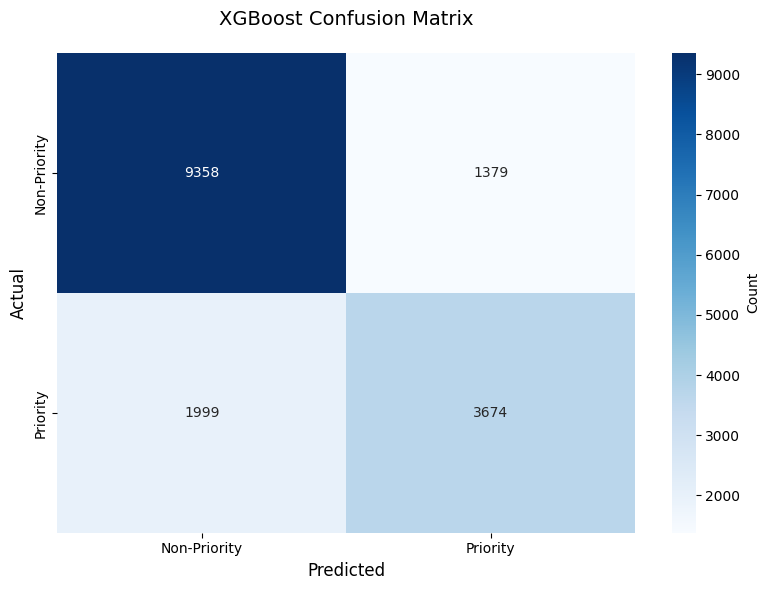


True Negatives (TN):  9358
False Positives (FP): 1379
False Negatives (FN): 1999
True Positives (TP):  3674


In [81]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Create a more detailed confusion matrix display
cm_df = pd.DataFrame(
    cm_xgb,
    index=['Non-Priority (Actual)', 'Priority (Actual)'],
    columns=['Non-Priority (Predicted)', 'Priority (Predicted)']
)

print("\n" + "=" * 60)
print("Confusion Matrix")
print("=" * 60)
print(cm_df)
print("\n")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_xgb, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Non-Priority', 'Priority'],
    yticklabels=['Non-Priority', 'Priority'],
    cbar_kws={'label': 'Count'}
)
plt.title('XGBoost Confusion Matrix', fontsize=14, pad=20)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and display additional metrics from confusion matrix
tn, fp, fn, tp = cm_xgb.ravel()
print(f"\nTrue Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")
print("=" * 60)
